# Inspecting and Analyzing Results of CF3I Power Scan 
Data taken July 22nd 2024  
Scan 2: 4.0 W after grating (50 degrees on waveplate)  
Scan 3: 3.5 W after grating (41 degrees on waveplate)  
Scan 4: 3.0 W after grating (38 degrees on waveplate)  
Scan 5: 2.5 W after grating (32 degrees on waveplate)  
Scan 6: 2.0 W after grating (30 degrees on waveplate)  
Scan 7: 1.5 W after grating (25 degrees on waveplate)  
Scan 8: 1.0 W after grating (20 degrees on waveplate)  
Scan 9: 0.5 W after grating (18 degrees on waveplate)  


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gued

%matplotlib widget

## Load Data

In [2]:
file_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\UV_IR_exp\\07222024\\Time_Scans\\'
file_name = file_path + "cf3i_ir_2024-07-23.h5"
print(file_name)
gued.inspect_h5(file_name)

C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\UV_IR_exp\07222024\Time_Scans\cf3i_ir_2024-07-23.h5
Group: scan_2
Dataset: scan_2/I_run_0
Dataset: scan_2/centers_run_0
Dataset: scan_2/clean_images_run_0
Dataset: scan_2/new_centers_run_0
Dataset: scan_2/percent_outliers_run_0
Dataset: scan_2/percent_xrays_run_0
Dataset: scan_2/stage_positions_run_0
Dataset: scan_2/total_counts_run_0
Group: scan_3
Dataset: scan_3/I_run_0
Dataset: scan_3/centers_run_0
Dataset: scan_3/clean_images_run_0
Dataset: scan_3/new_centers_run_0
Dataset: scan_3/percent_outliers_run_0
Dataset: scan_3/percent_xrays_run_0
Dataset: scan_3/stage_positions_run_0
Dataset: scan_3/total_counts_run_0


In [3]:
group_name = "scan_3"
#run_numbers = list(np.arange(0,9,1)) 
#print(run_numbers)
run_numbers = 'all'
# Don't read in the raw data (clean_images) unless you are not reading all images
variable_names = ["I", "centers", "new_centers", 
                  "percent_outliers", "percent_xrays", 
                  "stage_positions", "total_counts"]

In [4]:
# Read combined data
combined_data = gued.read_combined_data(file_name, group_name, variable_names, run_numbers=run_numbers)
print(combined_data.keys())
combined_I = combined_data['I']
combined_stage = combined_data['stage_positions']
combined_centers = combined_data['new_centers']

dict_keys(['I', 'centers', 'new_centers', 'percent_outliers', 'percent_xrays', 'stage_positions', 'total_counts'])


## View All Details

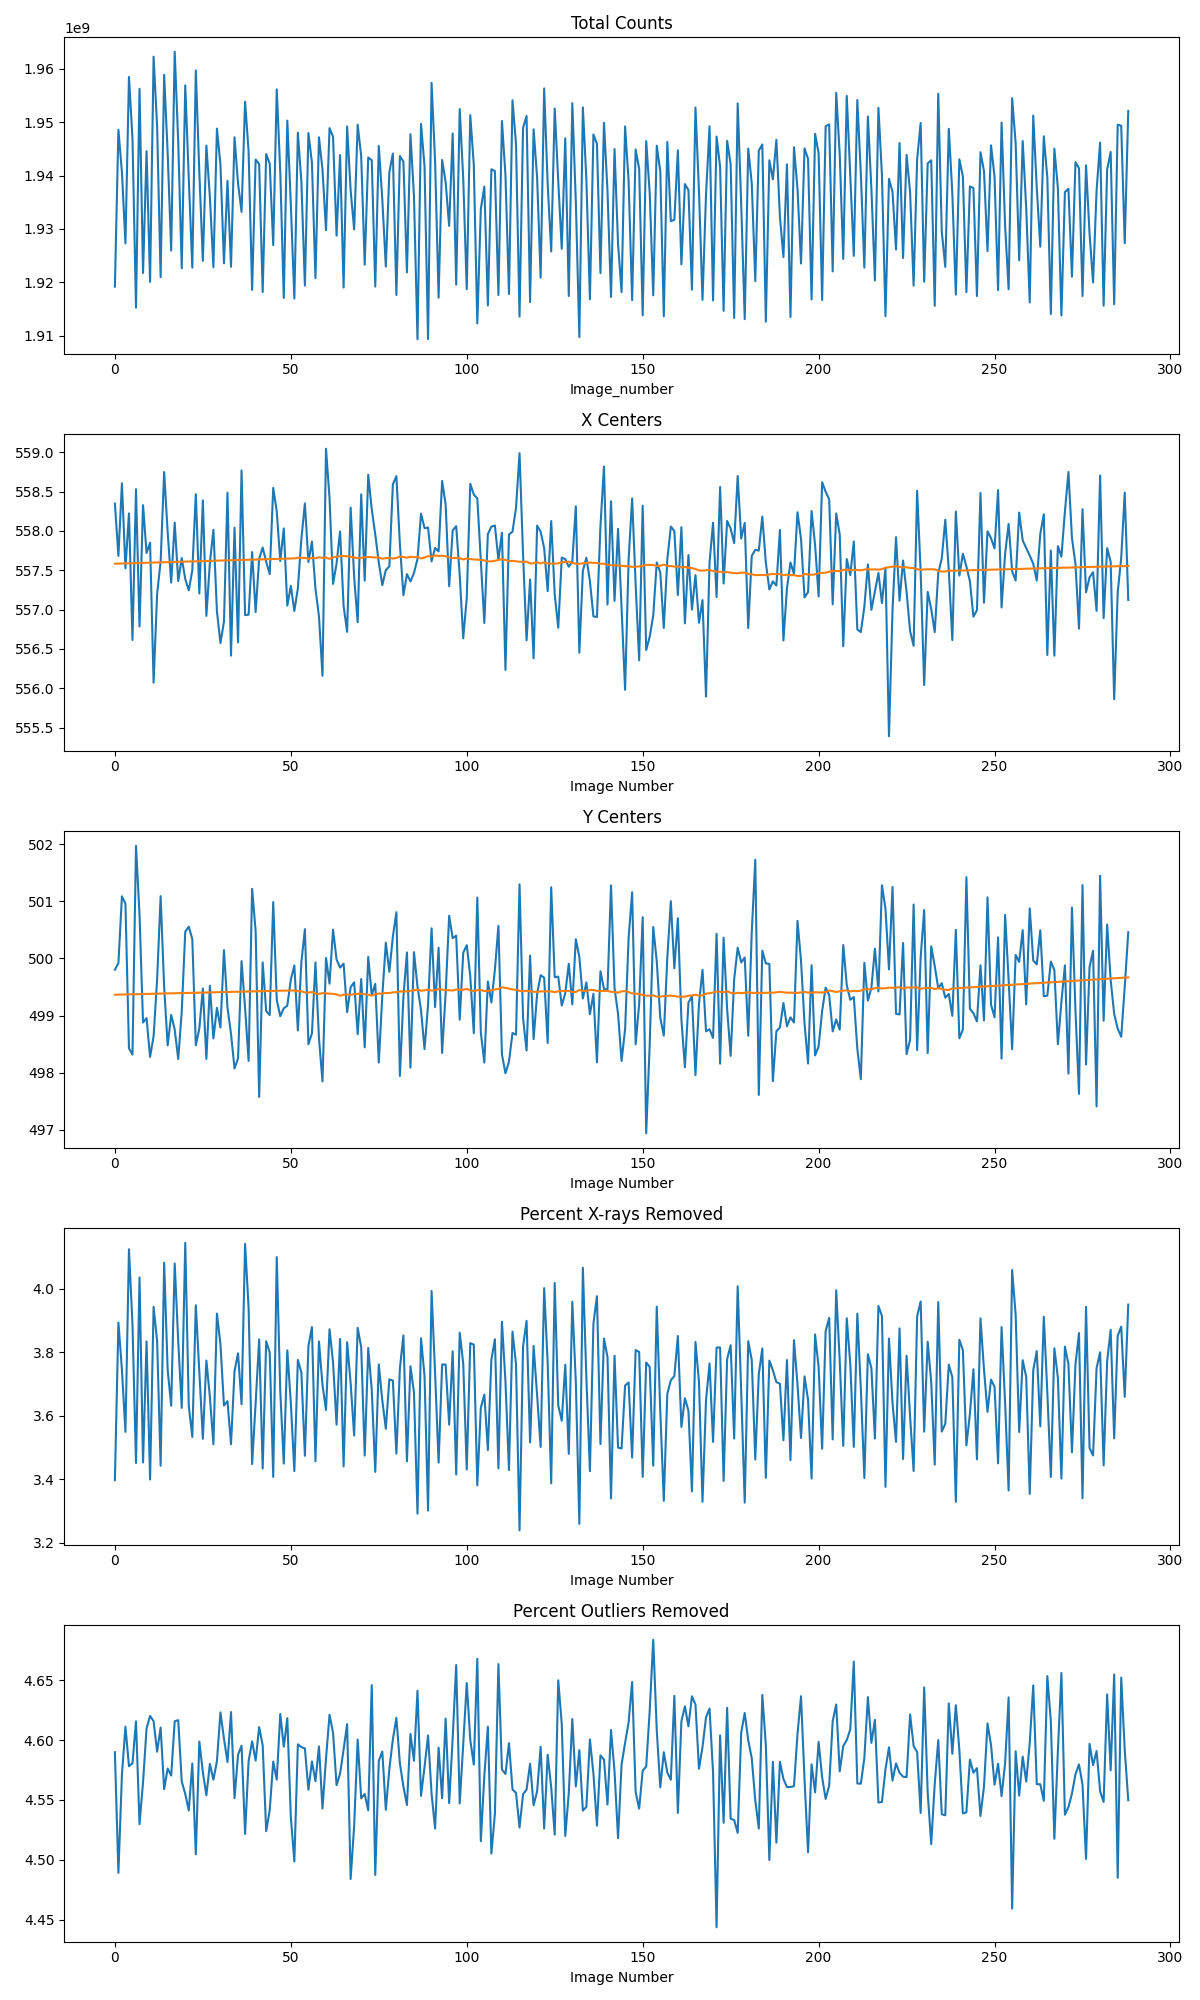

In [5]:
plt.figure(figsize=(12, 20))

plt.subplot(5, 1, 1)
plt.plot(combined_data['total_counts'])
plt.title("Total Counts")
plt.xlabel("Image_number")

plt.subplot(5, 1, 2)
plt.plot(combined_data['centers'][:,0])
plt.plot(combined_data["new_centers"][:,0])
plt.title("X Centers")
plt.xlabel("Image Number")

plt.subplot(5, 1, 3)
plt.plot(combined_data['centers'][:,1])
plt.plot(combined_data["new_centers"][:,1])
plt.title("Y Centers")
plt.xlabel("Image Number")

plt.subplot(5, 1, 4)
plt.plot(combined_data['percent_xrays'])
plt.title("Percent X-rays Removed")
plt.xlabel("Image Number")

plt.subplot(5, 1, 5)
plt.plot(combined_data['percent_outliers'])
plt.title("Percent Outliers Removed")
plt.xlabel("Image Number")

plt.tight_layout()
plt.show()


## Set Up Independent variables

In [6]:
uni_stage = uni_stage = np.unique(combined_stage) # Pump-probe stage position
s_cali = 0.0223 # S calibration in experiment
#s_cali = 0.02134
#posi_0    = 154.405 # time for s4
posi_0 = 97.55  # time zero for s1
s = np.arange(0,len(combined_I[0]))*s_cali # The Q axis
realtime = (uni_stage-posi_0)/0.15  # Delay axis in ps

## Averaging Based on Delay Position

In [7]:
stage_len = len(uni_stage);               #  Number of delays
azimuthal_data = np.ones((stage_len, len(combined_I[0]))); #  Delay dependent averaged pp images

if stage_len>20:
    prt_count = 5
else:
    prt_count = 1  
for i in range(stage_len):
    if i%prt_count == 0:
        print('Averaging data at stage posi # '+ str(i) + ', ' + str(uni_stage[i]) + ' mm') # Obtain a sub array to save the data in one delay
    stage_data = combined_I[np.where(combined_stage==uni_stage[i])[0]];
    azimuthal_data[i] = np.nanmean(stage_data,axis=0); # no subtracting background


Averaging data at stage posi # 0, 94.0 mm
Averaging data at stage posi # 1, 98.0 mm
Averaging data at stage posi # 2, 100.0 mm


## Plot dI/I 

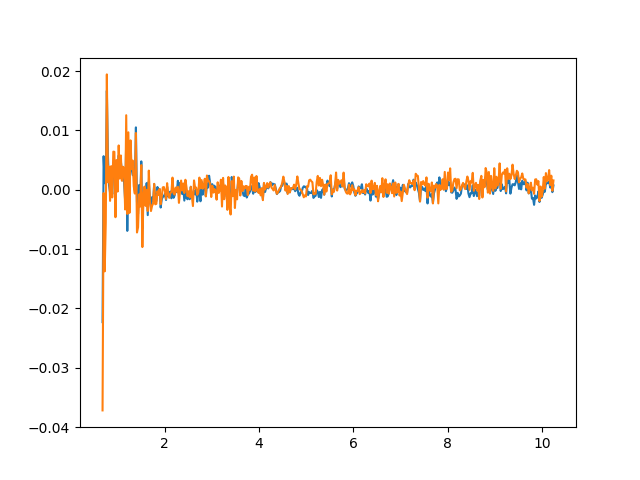

In [8]:
I_ref = azimuthal_data[0]
dI_I = (azimuthal_data-I_ref)/I_ref

# (3) Plot the figure: Plot the time-dependent signal
angs = '\u00C5'; # angstrom sign
s_cali = 0.0228 # S calibration in experiment
#s_cali = 0.02134
#posi_0    = 154.405 # The reference T0
posi_0 = 108.61
s = np.arange(0,len(azimuthal_data[0]))*s_cali # The Q axis
realtime = (uni_stage-posi_0)/0.15  # Delay axis in ps

plt.figure()
plt.plot(s, dI_I[1])
plt.plot(s, dI_I[2])
#plt.xlim(0,11)
#plt.ylim(-0.005, 0.005)
plt.show()

## Power Fit Data

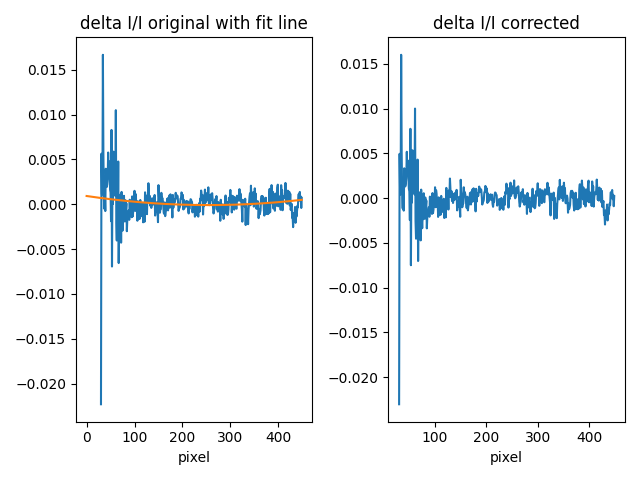

In [9]:
corrected_dI, baseline2d = gued.poly_fit(dI_I, s, return_baseline=True)
dI_I_ave = np.nanmean(dI_I, axis=0)
corrected_ave = np.nanmean(corrected_dI, axis=0)
baseline_ave = np.nanmean(baseline2d, axis=0)

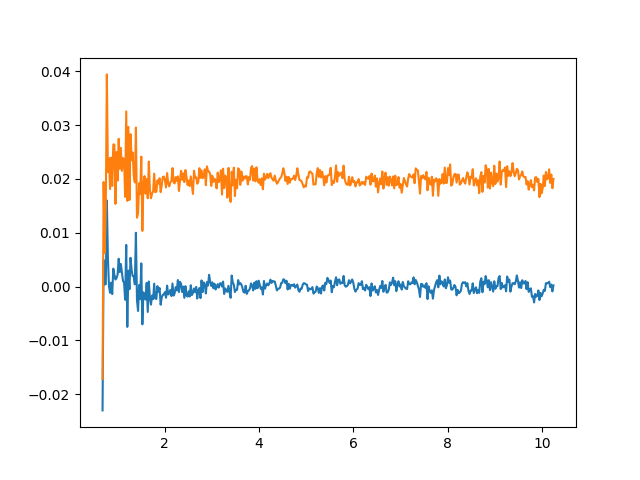

In [10]:

plt.figure()
plt.plot(s, corrected_dI[1])
plt.plot(s, corrected_dI[2]+0.02)
#plt.xlim(0,11)
#plt.ylim(-0.005, 0.005)
plt.show()